In [1]:
# Checking disk space
!df -m

# Checking my privileges 
!whoami

! mkdir /content/data/

! ls /opt/

!wget --no-check-certificate \
    http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat \
    -O /content/data/Indian_pines_corrected.mat

!wget --no-check-certificate \
    http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat \
    -O /content/data/Indian_pines_gt.mat

!wget --no-check-certificate \
    http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat \
    -O /content/data/Salinas_corrected.mat

!wget --no-check-certificate \
    http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat \
    -O /content/data/Salinas_gt.mat

!wget --no-check-certificate \
    http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat \
    -O /content/data/PaviaU.mat

!wget --no-check-certificate \
    http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat \
    -O /content/data/PaviaU_gt.mat

! cd /content/data/

Filesystem     1M-blocks  Used Available Use% Mounted on
overlay            70044 32956     37072  48% /
tmpfs                 64     0        64   0% /dev
tmpfs               6511     0      6511   0% /sys/fs/cgroup
shm                 5888     0      5888   0% /dev/shm
tmpfs               6511     1      6511   1% /var/colab
/dev/sda1          76392 34154     42222  45% /opt/bin
tmpfs               6511     0      6511   0% /proc/acpi
tmpfs               6511     0      6511   0% /proc/scsi
tmpfs               6511     0      6511   0% /sys/firmware
root
bin  google  nvidia
--2020-11-24 23:18:11--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘/content/data/Indian_pines_corrected.mat’

/content/data/India 100%[===================>]   5.68M   

In [3]:
!pip install spectral

     |████████████████████████████████| 215kB 8.6MB/s 


In [4]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [5]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [6]:
#Loading the data
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [7]:
#Spliting the Training Data and Testing Data
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [8]:
#Defining PCA to remove the spectral redundancy
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [9]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [10]:
#Dividing the HSI data cubes into small overlapping 3-D-patches
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [11]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [12]:
K = X.shape[2]
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [13]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [14]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

In [15]:
#Model, Training and Validation
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [16]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [17]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [18]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [19]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [20]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [21]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

callback_list = [ModelCheckpoint(filepath = "best-model.hdf5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')]

model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callback_list, validation_data=(Xtest, ytest))

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.4839 - accuracy: 0.2254
Epoch 00001: accuracy improved from -inf to 0.22544, saving model to best-model.hdf5
13/13 [==============================] - 5s 415ms/step - loss: 2.4839 - accuracy: 0.2254 - val_loss: 1.8867 - val_accuracy: 0.3803
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 1.5454 - accuracy: 0.4971
Epoch 00002: accuracy improved from 0.22544 to 0.49707, saving model to best-model.hdf5
13/13 [==============================] - 5s 394ms/step - loss: 1.5448 - accuracy: 0.4971 - val_loss: 1.0729 - val_accuracy: 0.6169
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 0.8614 - accuracy: 0.7197
Epoch 00003: accuracy improved from 0.49707 to 0.71991, saving model to best-model.hdf5
13/13 [==============================] - 5s 394ms/step - loss: 0.8611 - accuracy: 0.7199 - val_loss: 0.4224 - val_accuracy: 0.8645
Epoch 4/100
12/13 [==========================>...] - ETA: 0s 

In [29]:
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

X, y = loadData(dataset)

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K
X,pca = applyPCA(X, numComponents=numComponents)
X = padWithZeros(X, PATCH_SIZE//2)
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

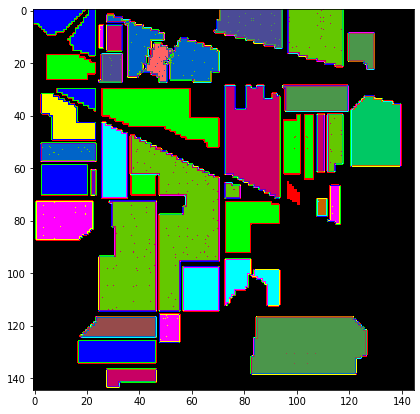

In [30]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

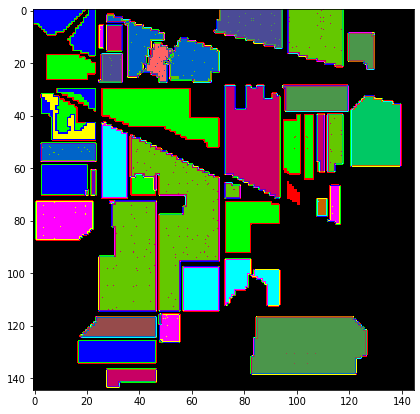

In [31]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))